In [1]:
#pip install importnb

In [2]:
# This notebook executes the training routines of the agent(s) 
import random
import time
from importnb import Notebook
with Notebook():
    import Board
    import Agent
from abc import ABC, abstractmethod
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
#### Parent Class ####

In [4]:
class Game(ABC):
    def __init__(self, board, agent1):
        """
        clase abstracta Game
        """
        self.board = board
        self.agent1 = agent1

    def reset_game(self):
        self.board.reset()

    @abstractmethod
    def play(self):
        pass # To be implemented by the child classes

In [5]:
#### Child Classes ####

In [6]:
class AgentVsAgent(Game):
    def __init__(self, board, agent1, agent2, epochs = 1):
        super().__init__(board, agent1)
        self.epochs = epochs
        self.agent2 = agent2
        if agent1.chip == agent2.chip:
            raise ValueError("Los agentes deben tener fichas diferentes")

    def plot_results(self, metrics):
        df = pd.DataFrame(metrics)
        
        # Contar las victorias y empates para cada jugador
        df['Jugador 1 Ganadas'] = df['Jugador 1'].apply(lambda x: 1 if x == 'G' else -1)
        df['Jugador 2 Ganadas'] = df['Jugador 2'].apply(lambda x: 1 if x == 'G' else -1)
        df['Empatadas'] = df['Jugador 2'].apply(lambda x: 0 if x == 'E' else -1)
        
        # Agrupar los resultados por Epoca y sumar las victorias y empates
        df_grouped = df.groupby('Epoca')[['Jugador 1 Ganadas', 'Jugador 2 Ganadas', 'Empatadas']].sum()
        
        # Graficar el timechart
        plt.figure(figsize=(10, 6))
        plt.plot(df_grouped.index, df_grouped['Jugador 1 Ganadas'], label='Jugador 1 - Ganadas', color='green', marker='o')
        plt.plot(df_grouped.index, df_grouped['Jugador 2 Ganadas'], label='Jugador 2 - Ganadas', color='blue', marker='o')
        plt.plot(df_grouped.index, df_grouped['Empatadas'], label='Empatadas', color='orange', marker='o')
        
        # Personalización del gráfico
        plt.title('Evolución de Partidas Ganadas y Empatadas entre Jugador 1 y Jugador 2')
        plt.xlabel('Epoca')
        plt.ylabel('Cantidad de Partidas')
        plt.legend()
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

    def plot_results_by_bar(self, metrics):
        print(metrics)
        df = pd.DataFrame(metrics)
        
        # Crear un DataFrame con los resultados filtrados
        resultados = pd.DataFrame({
            'Jugador 1': df['Jugador 1'].value_counts().loc[['G']].fillna(0),
            'Jugador 2': df['Jugador 2'].value_counts().loc[['G']].fillna(0),
            'Empatadas': df['Jugador 1'].value_counts().get('E', 0)
        })
        
        # Graficar solo las partidas ganadas y empatadas
        resultados.plot(kind='bar', color=['green', 'blue', 'yellow'], figsize=(8,6))
        plt.title('Partidas Ganadas y Empatadas entre Jugador 1 y Jugador 2')
        plt.xlabel('Resultado')
        plt.ylabel('Cantidad de Partidas')
        plt.xticks(rotation=0)
        plt.legend(['Jugador 1', 'Jugador 2', 'Empatadas'])
        plt.tight_layout()
        plt.show()

    def play(self, save_learning = True, plot_result = True, plot_result_by_bar = True):
        """Implementa los juegos entre los dos agentes."""
        metrics = {
            'Epoca': [],
            'Jugador 1': [],
            'Jugador 2': []
        }
        for epoch in range(self.epochs):
            start = time.time()
            self.reset_game()
            agent_1_turn = random.choice([True, False]) # randomize who gets first turn

            # An EPOCH
            while True :                
                
                if agent_1_turn:# Turno Agente 1
                    self.agent1.play_turn(episode = epoch)  
                        
                else: # Turno Agente 2
                    self.agent2.play_turn(episode = epoch)

                
                if self.board.isBoardFull() or self.board.verify_winner(self.agent1.chip) or self.board.verify_winner(self.agent2.chip):
                    break
         
                agent_1_turn = not agent_1_turn
            # END OF AN EPOCH
            j1 = ['G' if self.board.verify_winner(self.agent1.chip) else 'E' if self.board.isBoardFull() else 'P'][0]
            j2 = ['G' if self.board.verify_winner(self.agent2.chip) else 'E' if self.board.isBoardFull() else 'P'][0]
            metrics['Epoca'].append(epoch)            
            metrics['Jugador 1'].append(j1)
            metrics['Jugador 2'].append(j2)
            
            end = time.time()
            #if epoch%epoch == 0:
            print(f"Epoch # {epoch} took {(end - start):.3f} s")

        if plot_result:
            self.plot_results(metrics)
            
        if plot_result_by_bar:
            self.plot_results_by_bar(metrics)
            
        if save_learning:
            self.agent1.export_Qtable('Q_Table_A1.pkl')
            self.agent1.export_Qtable_JSON('Q_Table_A1.json')
            self.agent2.export_Qtable('Q_Table_A2.pkl')
            self.agent2.export_Qtable_JSON('Q_Table_A2.json')

In [7]:
class PlayerVsAgent(Game):
    def __init__(self, board, agent):
        super().__init__(board, agent)
        self.agent = agent
        #self.player_chip = ?
        if self.agent.chip == "X":
            self.player_chip = "O"
        else:
            self.player_chip = "X"

    def play(self):
        """Implementa un juego entre un humano y un agente."""
                
        play_again = True
        while play_again:
            
            self.reset_game()
            player_turn = random.choice([True, False]) # randomize who gets first turn
            if player_turn:
                print("You start this time")
            else:
                print("I will start this time")
            
            while True:         
                
                if player_turn:
                    # print the current state of the board
                    self.board.print_board()
                    print("It´s your turn!")

                    # Ask for the next move and place the chip
                    while True:
                        try:
                            user_input = input("What is your move? ")
                            new_col_number = int(user_input)  # Intentar convertir a entero
                            
                            # Verificar que el número esté dentro del rango permitido
                            if not (1 <= new_col_number <= 7):
                                raise ValueError("The column must be a number between 1 and 7.")
                            
                            # Intentar colocar la ficha en el tablero
                            if not self.board.place_chip(new_col_number, self.player_chip):
                                raise ValueError("Invalid move. The column might be full or invalid. Try again.")
                            
                            # Si el movimiento es válido, romper el bucle
                            break
                            
                        except ValueError as e:
                            print(e)
                            
                    if self.board.verify_winner(self.player_chip):
                        self.board.print_board()
                        print("YOU WIN!")
                        # comunicarle al agente que perdió -> asignar la recompensa 
                        break
                    elif self.board.isBoardFull():
                        self.board.print_board()
                        print("ITS A TIE")
                        # comunicarle al agente que empato -> asignar la recompensa 
                        break

                # FIN DEL TURNO DEL Jugador
                    
                else: # Agents Turn
                    
                    print("\nIt´s My turn!")
                    self.agent.play_turn()

                    if self.board.verify_winner(self.agent.chip):
                        self.board.print_board()
                        print("YOU LOSE!")
                        break
                    elif self.board.isBoardFull():
                        self.board.print_board()
                        print("ITS A TIE")
                        # comunicarle al agente que empato -> asignar la recompensa 
                        break

                
                    # FIN DEL TURNO DEL AGENTE

                player_turn = not player_turn

            # Juego terminó, preguntar si se quiere volver a jugar
            usr_input = ""
            while usr_input.lower() not in ["y", "n", "yes", "no"]:
                usr_input = input("Do you want to play again? (y/n): ").strip()

            if usr_input.lower() in ["y", "yes"]:
                play_again = True  # No es necesario redefinir, pero preferi dejarlo explícito
            elif usr_input.lower() in ["n", "no"]:
                play_again = False

        print("Thanks for playing, Bye!")

**Entrenamiento Agente VS Agente**

Epoch # 0 took 0.862 s
Epoch # 1 took 0.545 s
Epoch # 2 took 0.398 s
Epoch # 3 took 0.457 s
Epoch # 4 took 0.248 s
Epoch # 5 took 0.346 s
Epoch # 6 took 0.343 s
Epoch # 7 took 0.500 s
Epoch # 8 took 0.661 s
Epoch # 9 took 0.838 s
Epoch # 10 took 0.325 s
Epoch # 11 took 0.286 s
Epoch # 12 took 0.667 s
Epoch # 13 took 0.428 s
Epoch # 14 took 0.691 s
Epoch # 15 took 0.416 s
Epoch # 16 took 0.591 s
Epoch # 17 took 0.527 s
Epoch # 18 took 0.514 s
Epoch # 19 took 0.843 s
Epoch # 20 took 0.467 s
Epoch # 21 took 0.586 s
Epoch # 22 took 0.598 s
Epoch # 23 took 0.994 s
Epoch # 24 took 0.505 s
Epoch # 25 took 0.479 s
Epoch # 26 took 0.592 s
Epoch # 27 took 0.785 s
Epoch # 28 took 0.617 s
Epoch # 29 took 0.495 s
Epoch # 30 took 0.477 s
Epoch # 31 took 0.540 s
Epoch # 32 took 0.364 s
Epoch # 33 took 0.345 s
Epoch # 34 took 0.573 s
Epoch # 35 took 0.555 s
Epoch # 36 took 0.457 s
Epoch # 37 took 0.715 s
Epoch # 38 took 0.403 s
Epoch # 39 took 0.840 s
Epoch # 40 took 0.311 s
Epoch # 41 took 0.677 s
Ep

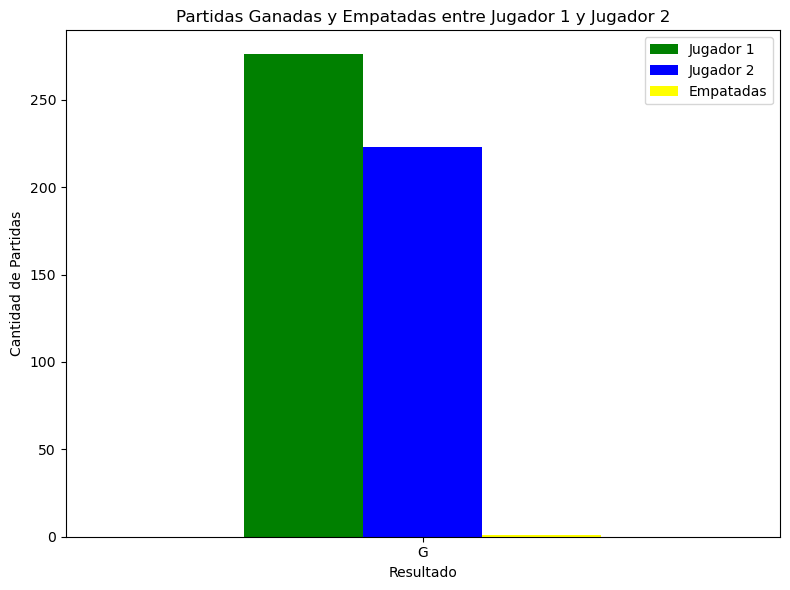

Q-table saved successfully
Q-table saved successfully


In [9]:
tablero = Board.Connect4Board()

agente = Agent.Agent(tablero, "O",epsilon=0.9,alpha=0.8,gamma=1)
otroAgente = Agent.Agent(tablero, "X")
juego = AgentVsAgent(tablero, agente, otroAgente, epochs = 500)
juego.play(plot_result=False)

**Prueba contra un agente aleatorio**

Q_Table_A2_30k_epsilon_09_alpha_08_gamma_1.pkl
Q-table load successfull
Epoch # 0 took 0.704 s
Epoch # 1 took 0.923 s
Epoch # 2 took 0.611 s
Epoch # 3 took 0.977 s
Epoch # 4 took 1.074 s
Epoch # 5 took 0.267 s
Epoch # 6 took 0.647 s
Epoch # 7 took 0.565 s
Epoch # 8 took 0.464 s
Epoch # 9 took 0.498 s
Epoch # 10 took 0.372 s
Epoch # 11 took 0.795 s
Epoch # 12 took 0.187 s
Epoch # 13 took 1.121 s
Epoch # 14 took 0.504 s
Epoch # 15 took 0.416 s
Epoch # 16 took 1.099 s
Epoch # 17 took 0.536 s
Epoch # 18 took 0.561 s
Epoch # 19 took 0.414 s
Epoch # 20 took 0.387 s
Epoch # 21 took 0.450 s
Epoch # 22 took 0.504 s
Epoch # 23 took 1.014 s
Epoch # 24 took 0.345 s
Epoch # 25 took 0.581 s
Epoch # 26 took 0.361 s
Epoch # 27 took 0.541 s
Epoch # 28 took 0.725 s
Epoch # 29 took 0.539 s
Epoch # 30 took 0.509 s
Epoch # 31 took 0.546 s
Epoch # 32 took 0.332 s
Epoch # 33 took 0.286 s
Epoch # 34 took 0.275 s
Epoch # 35 took 0.535 s
Epoch # 36 took 0.271 s
Epoch # 37 took 0.231 s
Epoch # 38 took 0.609 s
Ep

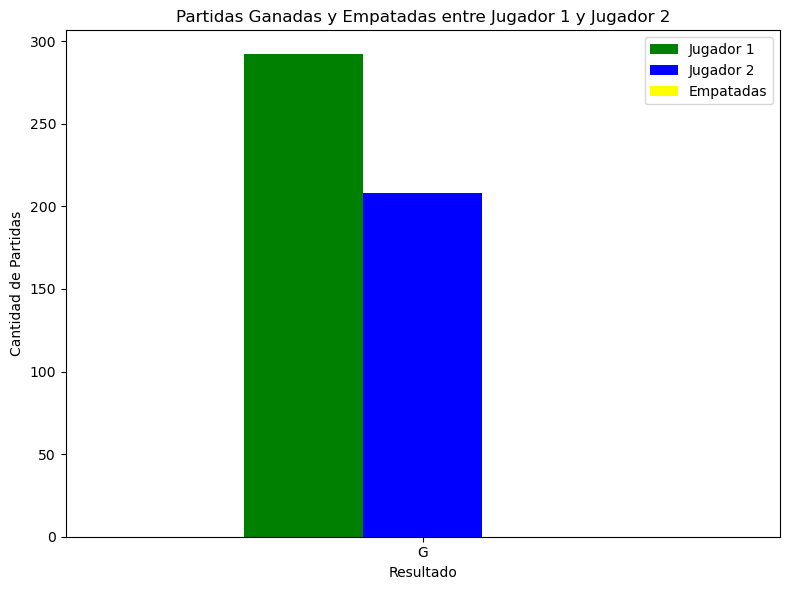

In [11]:
tablero = Board.Connect4Board()
agenteCarga = Agent.Agent(tablero, "O", filename = 'Q_Table_A2_30k_epsilon_09_alpha_08_gamma_1.pkl')
agenteAleatorio = Agent.Agent(tablero, "X", is_random = True)
juego = AgentVsAgent(tablero, agenteCarga, agenteAleatorio, epochs = 500)
juego.play(save_learning = False, plot_result = False, plot_result_by_bar = True)

**Aleatorio VS Aleatorio**

Epoch # 0 took 0.918 s
Epoch # 1 took 0.809 s
Epoch # 2 took 0.358 s
Epoch # 3 took 0.673 s
Epoch # 4 took 0.520 s
Epoch # 5 took 0.693 s
Epoch # 6 took 0.743 s
Epoch # 7 took 0.504 s
Epoch # 8 took 0.790 s
Epoch # 9 took 0.602 s
Epoch # 10 took 0.436 s
Epoch # 11 took 0.785 s
Epoch # 12 took 0.485 s
Epoch # 13 took 0.439 s
Epoch # 14 took 0.667 s
Epoch # 15 took 0.362 s
Epoch # 16 took 1.298 s
Epoch # 17 took 0.400 s
Epoch # 18 took 0.504 s
Epoch # 19 took 0.402 s
Epoch # 20 took 0.265 s
Epoch # 21 took 0.823 s
Epoch # 22 took 0.315 s
Epoch # 23 took 0.889 s
Epoch # 24 took 0.595 s
Epoch # 25 took 0.376 s
Epoch # 26 took 0.441 s
Epoch # 27 took 0.622 s
Epoch # 28 took 0.490 s
Epoch # 29 took 0.499 s
Epoch # 30 took 0.363 s
Epoch # 31 took 0.832 s
Epoch # 32 took 0.647 s
Epoch # 33 took 0.521 s
Epoch # 34 took 0.674 s
Epoch # 35 took 0.520 s
Epoch # 36 took 0.869 s
Epoch # 37 took 1.296 s
Epoch # 38 took 0.310 s
Epoch # 39 took 0.933 s
Epoch # 40 took 0.671 s
Epoch # 41 took 1.107 s
Ep

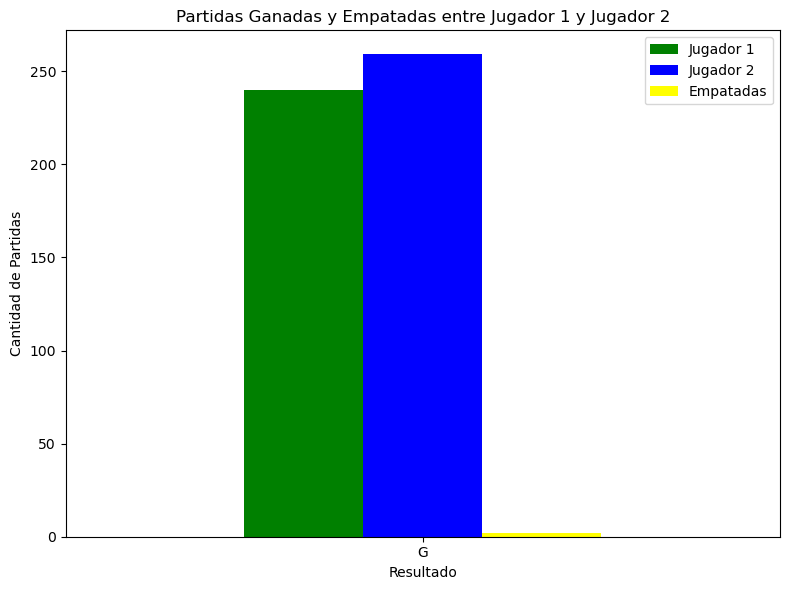

In [13]:
tablero = Board.Connect4Board()
agenteAleatorio1 = Agent.Agent(tablero, "O", is_random = True)
agenteAleatorio2 = Agent.Agent(tablero, "X", is_random = True)
juego = AgentVsAgent(tablero, agenteAleatorio1, agenteAleatorio2, epochs = 500)
juego.play(save_learning = False, plot_result = False, plot_result_by_bar = True)

# **Ejecutar la siguiente sección si se quiere jugar contra el Agente**

**Prueba Mejor Agente VS Humano**

In [16]:
tablero = Board.Connect4Board()
agenteCarga = Agent.Agent(tablero, "O", filename = 'Q_Table_A2_30k_epsilon_09_alpha_08_gamma_1.pkl')
juego = PlayerVsAgent(tablero, agenteCarga)
juego.play()

Q_Table_A2_30k_epsilon_09_alpha_08_gamma_1.pkl
Q-table load successfull
I will start this time

It´s My turn!


        <<<<<<<<   CONNECT4  >>>>>>>>
  Col_1 Col_2 Col_3 Col_4 Col_5 Col_6 Col_7
0     -     -     -     -     -     -     -
1     -     -     -     -     -     -     -
2     -     -     -     -     -     -     -
3     -     -     -     -     -     -     -
4     -     -     -     -     -     -     -
5     -     -     O     -     -     -     -


It´s your turn!


What is your move?  4



It´s My turn!


        <<<<<<<<   CONNECT4  >>>>>>>>
  Col_1 Col_2 Col_3 Col_4 Col_5 Col_6 Col_7
0     -     -     -     -     -     -     -
1     -     -     -     -     -     -     -
2     -     -     -     -     -     -     -
3     -     -     -     -     -     -     -
4     -     -     -     -     -     -     -
5     O     -     O     X     -     -     -


It´s your turn!


What is your move?  2



It´s My turn!


        <<<<<<<<   CONNECT4  >>>>>>>>
  Col_1 Col_2 Col_3 Col_4 Col_5 Col_6 Col_7
0     -     -     -     -     -     -     -
1     -     -     -     -     -     -     -
2     -     -     -     -     -     -     -
3     -     -     -     -     -     -     -
4     -     -     -     O     -     -     -
5     O     X     O     X     -     -     -


It´s your turn!


What is your move?  5



It´s My turn!


        <<<<<<<<   CONNECT4  >>>>>>>>
  Col_1 Col_2 Col_3 Col_4 Col_5 Col_6 Col_7
0     -     -     -     -     -     -     -
1     -     -     -     -     -     -     -
2     -     -     -     -     -     -     -
3     -     -     -     O     -     -     -
4     -     -     -     O     -     -     -
5     O     X     O     X     X     -     -


It´s your turn!


What is your move?  3



It´s My turn!


        <<<<<<<<   CONNECT4  >>>>>>>>
  Col_1 Col_2 Col_3 Col_4 Col_5 Col_6 Col_7
0     -     -     -     -     -     -     -
1     -     -     -     -     -     -     -
2     -     -     -     O     -     -     -
3     -     -     -     O     -     -     -
4     -     -     X     O     -     -     -
5     O     X     O     X     X     -     -


It´s your turn!


What is your move?  4



It´s My turn!


        <<<<<<<<   CONNECT4  >>>>>>>>
  Col_1 Col_2 Col_3 Col_4 Col_5 Col_6 Col_7
0     -     -     -     -     -     -     -
1     -     -     -     X     -     -     -
2     -     -     -     O     -     -     -
3     -     -     -     O     -     -     -
4     -     -     X     O     -     -     -
5     O     X     O     X     X     -     O


It´s your turn!


What is your move?  5



It´s My turn!


        <<<<<<<<   CONNECT4  >>>>>>>>
  Col_1 Col_2 Col_3 Col_4 Col_5 Col_6 Col_7
0     -     -     -     -     -     -     -
1     -     -     -     X     -     -     -
2     -     -     -     O     -     -     -
3     -     -     -     O     -     -     -
4     -     -     X     O     X     -     O
5     O     X     O     X     X     -     O


It´s your turn!


What is your move?  5



It´s My turn!


        <<<<<<<<   CONNECT4  >>>>>>>>
  Col_1 Col_2 Col_3 Col_4 Col_5 Col_6 Col_7
0     -     -     -     -     -     -     -
1     -     -     -     X     -     -     -
2     -     -     -     O     -     -     -
3     -     -     -     O     X     -     O
4     -     -     X     O     X     -     O
5     O     X     O     X     X     -     O


It´s your turn!


What is your move?  5




        <<<<<<<<   CONNECT4  >>>>>>>>
  Col_1 Col_2 Col_3 Col_4 Col_5 Col_6 Col_7
0     -     -     -     -     -     -     -
1     -     -     -     X     -     -     -
2     -     -     -     O     X     -     -
3     -     -     -     O     X     -     O
4     -     -     X     O     X     -     O
5     O     X     O     X     X     -     O


YOU WIN!


Do you want to play again? (y/n):  n


Thanks for playing, Bye!


# Discusión

## Resultados

Tras correr diferentes iteraciones de entrenamiento y evaluar diferentes agentes, se logra obtener un agente capaz de jugar con un mejor rendimiento que uno que juega de manera aleatoria. Esto demuestra una capacidad para tomar decisiones que van en pro de maximizar la recompensa que va asociada con un resultado positivo al jugar Connect4 en cuanto a las estrategias/politicas y al resultado final del juego. El código aqui presentado es capaz de correr en dos modalidades:

- AgenteVsAgente: para entrenar al agente por una cantidadde epocas dada por parámetro. Esto genera dos archivos con las Q-tablas de los agentes que pueden ser utilizadas para futuras instancias
- JugadorVsAgente: que permite a un humano jugar en contra de un agente, el cual carga una Q-tabla ingresada por parametro (que fue el resultado de un entrenamiento previo)

## **Desarrollo del Agente con Q-Learning**

Para el desarrollo del agente se decidió utilizar el método de **Q-learning** sobre otros métodos vistos en clase gracias a su velocidad de convergencia comparado con otros métodos y sus garantías teóricas de convergencia a la politica óptima. Otro punto a tener en cuenta fue la capacidad de generar nuevas políticas a través de las épocas del entrenamiento, lo que da cierta holgura a la hora de diseñar las políticas, ya que si estas están mal planteadas desde el principio este método *off-policy*, con su entrenamiento, tenderá a llegar a las políticas más óptimas para la solución del problema.

Un tema bastante importante a la hora de desarrollar este agente es la definición del conjunto de estados, acciones y recompensas sobre las cuales se aprenderá.

---

## **Definición del conjunto de estados del ambiente**

Dado que los estados globales del ambiente en Connect 4 se actualizan cada vez que un jugador realiza un movimiento colocando una ficha y que en un juego estándar hay 6 filas y 7 columnas (sumando un total de 42 celdas), y cada celda puede tomar valores de `‘X’, ’O’` y `‘-’`, esto llevaría a tener un total de posibles estados de:

\[
3^{42} \approx 1.094 \times 10^{20}
\]

Esta es una cantidad de estados demasiado grande, por lo que se decidió abstraer el estado actual a uno cuya representación sea menor. La representación de estados utilizada fue la siguiente:

Un vector con longitud 7, donde el valor de cada posición es una tupla compuesta por:
- La cantidad de fichas propias vecinas (consecutivas).
- La cantidad de fichas oponentes vecinas (consecutivas).

Cada posición de la tupla tiene valores entre 0 y 4. Un ejemplo de esta representación vectorial del estado es:

\[
[(1, 2), (2, 3), (0, 0), (3, 2), (2, 2), (3, 3), (1, 1)]
\]

---

## **Definición de las acciones del agente**

La dinámica del juego consiste en poner una ficha (amarilla o roja) en cada turno, con el objetivo de tener 4 fichas en línea. Por lo tanto, las posibles acciones son tantas como columnas tenga el tablero. Si el tablero es de 6x7, existen 7 posibles acciones, las cuales son válidas si y solo si el estado de la última casilla de la columna es `“Vacío”`. Por ejemplo:

Si el estado de la casilla con coordenadas `(0, 1)` es igual a `“Amarillo”`, entonces esa acción no será posible:

\[
a_n \iff s(0,1) = "Vacío"
\]

---

## **Función de recompensa**

La función de recompensa para el agente se definió de la siguiente manera:

| Acción                                      | Descripción                                   | Recompensa |
|--------------------------------------------|-----------------------------------------------|------------|
| Poner ficha con 0 propias consecutivas     | La jugada no lleva a que el juego termine     | 0          |
| Poner ficha con 1 propias consecutivas     | La jugada no lleva a que el juego termine     | 20         |
| Poner ficha con 2 propias consecutivas     | La jugada no lleva a que el juego termine     | 50         |
| Poner ficha con 3 propias consecutivas     | La jugada acerca al agente a ganar           | 200        |
| Poner ficha con 4 propias consecutivas     | La jugada hace ganar                         | 500        |
| Poner ficha con 0 del oponente consecutivas| La jugada no lleva a que el juego termine     | 0          |
| Poner ficha con 1 del oponente consecutivas| La jugada no lleva a que el juego termine     | 5          |
| Poner ficha con 2 del oponente consecutivas| La jugada no lleva a que el juego termine     | 15         |
| Poner ficha con 3 del oponente consecutivas| La jugada impide al oponente ganar           | 70         |
| Poner ficha con 4 del oponente consecutivas| El oponente gana                             | -100       |

---

## **Observaciones**

Después de la implementación y pruebas del agente se observó que, debido a la gran cantidad de posibles estados, sería necesario entrenar con millones de épocas. Esto requeriría muchos recursos como almacenamiento y tiempo de máquina. Esto teniendo en cuenta que se hizo una abstracción de los estados que permite reducir su dimensión enormemente da cuenta de las magnitudes de recursos que se requieren para entrenar modelos que sean capaces de lidiar con problemas como este.

El mejor agente se obtuvo con **30,000 épocas** y los resultados de este se exponen en als gráficas presentadas en este notebook. Esto que puede indicar un estancamiento un mínimo local, ya que un agente entrenado con **60,000 épocas** se comportaba de manera similar o peor que el de 30,000 épocas. 

Como trabajo a futuro, se podría experimentar aumentando el número de épocas y variando el **decaimiento del epsilon**, con el fin de que el agente explore aún más posibles estados. Sin embargo, esto debe ir acompañado de un entrenamiento más exhaustivo (con mayor cantidad de épocas de entrenamiento). Asi mismo sería preciso estudiar juiciosamente el efecto de los otros parametros de entrenamiento como la **tasa de aprendizaje** (alpha), la cantidad de epocas y el **factor de descuento** (Gamma) con el fin de llegar a una buena sintonización de los mismos y obtener un agente más óptimo al entrenarse. Otras representaciónes de los estados llevarán a distintos resultados y es algo que también sería interesante explorar.

Por último se propone pensar también en maneras de embeber estrategias deseadas en el agente. Por ejemplo, en una etapa temprana se pensó incluir en los estados y posteriormente en el esquema de recompensas información pertinente al número de casillas en la columna 4 del tablero. Esto con el fin de encaminar al algoritmo un poco hacia la estrategia de dominar esta columna ya que encontramos algunas fuentes donde se recomedaba esta estrategia para obtener buenos resultados al jugar Connect4. Esto podría afectar el rendimiento del agente y su velocidad de convergencia hacia una pólitica con excelente rendimiento.